# SYDE 556/750 --- Assignment 3
**Student ID: 20814292**

*Note:* Please include your numerical student ID only, do *not* include your name.

*Note:* Refer to the [PDF](https://github.com/celiasmith/syde556-f22/raw/master/assignments/assignment_03/syde556_assignment_03.pdf) for the full instructions (including some hints), this notebook contains abbreviated instructions only. Cells you need to fill out are marked with a "writing hand" symbol. Of course, you can add new cells in between the instructions, but please leave the instructions intact to facilitate marking.

In [109]:
# Import numpy and matplotlib -- you shouldn't need any other libraries
import numpy as np
import matplotlib.pyplot as plt

# Fix the numpy random seed for reproducible results
np.random.seed(18945)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

# 1. Decoding from a population

**a) Tuning curves.** Plot the tuning curves (firing rate of each neuron for different $x$ values between $-2$ and $2$).

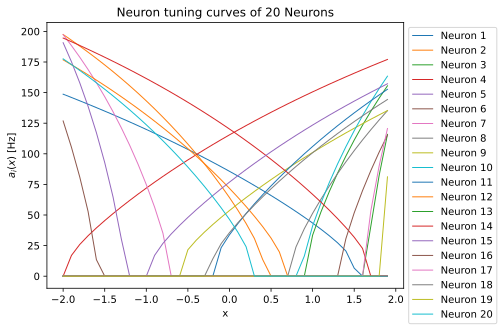

In [110]:
n = 20 # number of neurons
dx = 0.1  # step size
radius = 2.0
x = np.arange(-int(radius), int(radius), dx)
tau_ref = 2.0e-3    
tau_RC = 20.0e-3

maximum_firing_rates = np.random.uniform(100, 200, size=(n, 1))
x_intercepts = np.random.uniform(-radius, radius, size=(n, 1))
encoders = np.random.choice([1, -1], size=(n, 1))

def G(_J: np.ndarray):
    _J[_J > 1] = 1.0 / (tau_ref - tau_RC * np.log(1 - (1/_J[_J > 1])))
    _J[_J <= 1] = 0
    return _J

alphas = (- 1.0 + (1.0 / (1.0 - np.exp((1.0 / tau_RC) * (tau_ref - (1.0 / maximum_firing_rates)))))) / (radius - x_intercepts)
j_bias = (radius - (x_intercepts / (1.0 - np.exp((1.0 / tau_RC) * (tau_ref - (1.0 / maximum_firing_rates)))))) / (radius - x_intercepts)

A = G(alphas * encoders @ x.reshape(1, len(x)) + j_bias)

for i in range(n):
    plt.plot(x, A[i, :], label=f'Neuron {i+1}', linewidth='1')

plt.title(f"Neuron tuning curves of {n} Neurons")
plt.xlabel('x')
plt.ylabel('$a_{i}(x)$ [Hz]')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

**b) Decoder and error computation.** Compute the decoders and plot $(x-\hat{x})$. When computing decoders, take into account noise ($\sigma=0.1 \cdot 200\,\mathrm{Hz}$). When computing $\hat{x}$, add random Gaussian noise with $\sigma=0.1 \cdot 200\,\mathrm{Hz}$ to the activity. Report the Root Mean-Squared Error (RMSE).

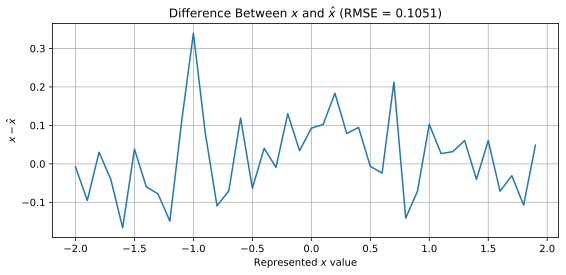

In [111]:
def rmse(_actual, _predicted):
    return np.sqrt(np.mean((_actual - _predicted) ** 2))

sigma = 0.1 * 200
noise = np.random.normal(0, sigma, size=A.shape)
noisy_A = A + noise
noisy_D = np.array(np.linalg.lstsq(A @ A.T + len(x) * np.square(sigma) * np.eye(n), A @ x, rcond=None)[0])
x_hat = noisy_A.T @ noisy_D
noisy_A_noisy_D_RMSE = rmse(x, x_hat)

# Plot the difference x - x_hat
plt.figure(figsize=(8, 4))
plt.plot(x, x - x_hat)
plt.title('Difference Between $x$ and $\hat{x}$' + f' (RMSE = {noisy_A_noisy_D_RMSE:.4f})')
plt.xlabel('Represented $x$ value')
plt.ylabel('$x - \hat{x}$')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Decoding from two spiking neurons

**a) Synaptic filter.** Plot the post-synaptic current
		$$
			h(t)= \begin{cases}
				0 & \text{if } t < 0 \,, \\
				\frac{e^{-t/\tau}}{\int_0^\infty e^{-t'/\tau} \mathrm{d}t'} & \text{otherwise} \,.
			\end{cases}
		$$

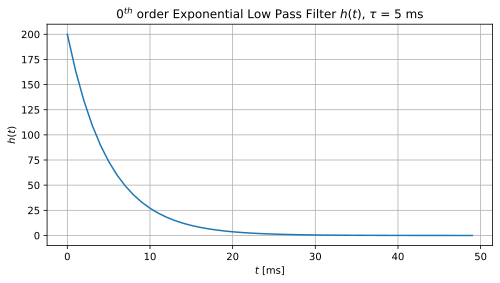

In [112]:
tau = 5e-3  # [s]
T = 0.05  # max time 0.1 seconds, appropriate amount of time for filter window, as h(t) ~= 0 beyond 0.1 seconds
dt = 1e-3 # [s]
filter_t = np.arange(0, T, dt)

def h_n0(_time_vector, _tau):
    return np.where(_time_vector >= 0, np.exp(-_time_vector / _tau) / _tau, 0)
h_n0_t = h_n0(filter_t, tau)

plt.figure(figsize=(8, 4))
plt.plot(filter_t * 1000, h_n0_t)
plt.title(r'$0^{th}$ order Exponential Low Pass Filter $h(t)$, $\tau$ = ' + f'{tau * 1000:.0f} ms')
plt.xlabel('$t$ [ms]')
plt.ylabel('$h(t)$')
plt.grid()
plt.show()

**b) Decoding using a synaptic filter.** Plot the original signal $x(t)$, the spikes, and the decoded $\hat{x}(t)$ all on the same graph.

In [113]:
T = 1.0  # Total time [s]
dt = 1e-3  # Time step [s]
limit = 5
rms = 1
normalized_spike_voltage = 5.0 # arbitrarily chosen
resting_voltage = 0.0 # [V]
threshold_voltage = 1.0 # [V]

index_of_zero = int(2 / dx)
A_at_zero = A[:, index_of_zero]
selected_neuron_index = np.where((A_at_zero >= 20) & (A_at_zero <= 50))[0][0]
selected_alpha = alphas[selected_neuron_index][0]
selected_j_bias = j_bias[selected_neuron_index][0]

In [114]:
def generate_band_limited_white_noise(_T, _dt, _rms, _limit, _seed:int = 0):
    np.random.seed(_seed)

    _N = int(_T / _dt) # total # of samples
    _t = np.arange(0, _T, _dt)

    _w = 2 * np.pi * np.fft.fftfreq(_N, d=_dt) # units = [rad/s]
    
    # Create random values for the positive frequency components
    _X_w_positive = np.random.randn(_N//2 + 1) + 1j * np.random.randn(_N//2 + 1)
    
    # Mirror values from positive to negative frequencies
    _X_w = np.zeros(_N, dtype=complex)
    _X_w[:_N//2 + 1] = _X_w_positive
    _X_w[_N//2 + 1:] = np.conjugate(_X_w_positive[1:-1][::-1])

    # Apply frequency limit by setting components above limit to zero
    _X_w[np.abs(_w) > (2 * np.pi * _limit)] = 0
    
    _x_t = np.fft.ifft(_X_w).real

    # Scale the signal to match the desired rms
    _rms_correction_factor = _rms / np.sqrt(np.mean(_x_t**2))
    _x_t *= _rms_correction_factor
    _X_w = _rms_correction_factor * _X_w

    return _t, _x_t, np.fft.fftshift(_w), np.fft.fftshift(_X_w)

t, x_t, _, _ = generate_band_limited_white_noise(T, dt, rms, limit)

In [115]:
def simulate_LIF_neuron(_x_t, _dt, _initial_state, _threshold_voltage, _normalized_spike_voltage, _tau_RC,  _e: list, _alpha: list, _j_bias: list):
    def J(_x, _e, _alpha, _j_bias):
        return _alpha * _e * _x + _j_bias # _x is a scalar
    
    _V_x_arr = []
    assert len(_e) == len(_alpha)
    assert len(_alpha) == len(_j_bias)

    for i in range(len(_e)):
        _V_x = []
        for curr_x in _x_t:
            if len(_V_x) == 0:
                _V_x.append(_initial_state)
                continue
            elif _V_x[-1] < 0:
                _V_x.append(0)
                continue
            elif _V_x[-1] < _threshold_voltage and _V_x[-1] >= 0:
                _dv = _dt * (1 / _tau_RC) * (J(curr_x, _e[i], _alpha[i], _j_bias[i]) - _V_x[-1]) 
            elif _V_x[-1] >= _threshold_voltage and _V_x[-1] < _normalized_spike_voltage:
                _dv = _normalized_spike_voltage - _V_x[-1]
            else:
                _dv = -_normalized_spike_voltage
            _V_x.append(_V_x[-1] + _dv)
        _V_x_arr.append(_V_x)
    return np.array(_V_x_arr)

def filter_signal(_signal):
    filtered_signal = np.zeros(len(_signal))
    
    # Loop through the signal and apply the filter h(t) at each spike location
    for i, curr_signal in enumerate(_signal):
        if curr_signal == normalized_spike_voltage:
            if i + len(h_n0_t) <= len(_signal):
                filtered_signal[i:i+len(h_n0_t)] += h_n0_t
            else: # Handle case when spike occurs near the end, trim h_n0_t accordingly
                filtered_signal[i:] += h_n0_t[:len(_signal) - i]
    
    return filtered_signal

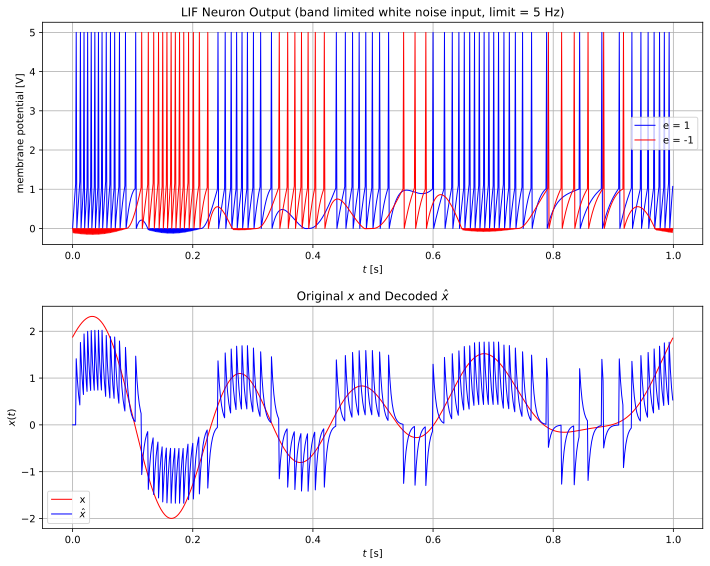

In [116]:
V_x_band_limited_white_noise_input = simulate_LIF_neuron(x_t, dt, resting_voltage, threshold_voltage, normalized_spike_voltage, tau_RC, [1, -1], 2*[selected_alpha], 2*[selected_j_bias])
V_x_band_limited_white_noise_input_filtered = np.apply_along_axis(filter_signal, axis=1, arr=V_x_band_limited_white_noise_input)
D = np.array(np.linalg.lstsq(V_x_band_limited_white_noise_input_filtered.T, x_t, rcond=None)[0])
x_hat_t = V_x_band_limited_white_noise_input_filtered.T @ D

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].plot(t, V_x_band_limited_white_noise_input[0], color='b', label='e = 1', linewidth='1')
axs[0].plot(t, V_x_band_limited_white_noise_input[1], color='r', label='e = -1', linewidth='1')
axs[0].set_title(f'LIF Neuron Output (band limited white noise input, limit = {limit} Hz)')
axs[0].set_xlabel('$t$ [s]')
axs[0].set_ylabel('membrane potential [V]')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(t, x_t, color='r', label='x', linewidth='1')
axs[1].plot(t, x_hat_t, color='b', label='$\hat{x}$', linewidth='1')
axs[1].set_title('Original $x$ and Decoded $\hat{x}$')
axs[1].set_xlabel('$t$ [s]')
axs[1].set_ylabel('$x(t)$')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

**c) Error analysis.** Compute the RMSE of the decoding.

In [117]:
x_hat_t_RMSE = rmse(x_t, x_hat_t)
print(x_hat_t_RMSE)

0.6037117544304942


# 3. Decoding from many neurons

**a) Exploring the error for an increasing neuron count.** Plot the Root Mean-Squared Error as the number of neurons increases, on a log-log plot. Try $8$ neurons, $16$ neurons, $32$, $64$, $128$, up to $256$. For the RMSE for a particular number of neurons, average over at least $5$ randomly generated groups of neurons. For each group of neurons, randomly generate the signal $x(t)$. Use the same parameters as in question 2.

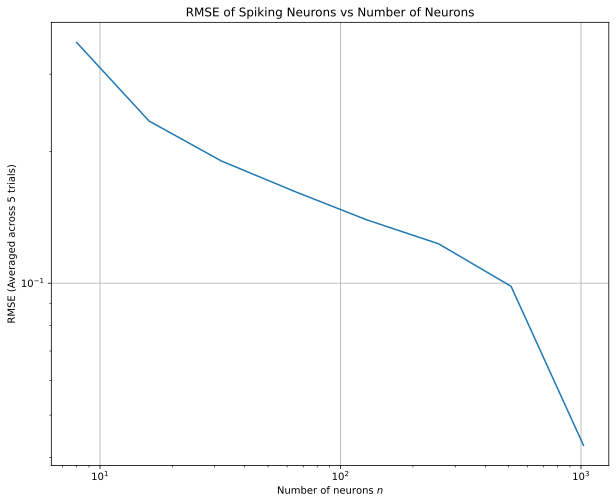

In [118]:
n_arr = [2**i for i in range(3, 11)]
num_of_runs = 5
T = 1.0  # Total time [s]
dt = 1e-3  # Time step [s]
limit = 5
rms = 1

RMSE_n = []

for curr_n in n_arr:
    RMSE_avg = []

    for i in range(num_of_runs):
        _, x_t, _, _ = generate_band_limited_white_noise(T, dt, rms, limit, _seed=(i+42))

        maximum_firing_rates = np.random.uniform(100, 200, size=(curr_n, 1))
        x_intercepts = np.random.uniform(-2, 2, size=(curr_n, 1)) 
        encoders = np.random.choice([1, -1], size=(curr_n, 1))

        alphas = (- 1.0 + (1.0 / (1.0 - np.exp((1.0 / tau_RC) * (tau_ref - (1.0 / maximum_firing_rates)))))) / (1.0 - x_intercepts)
        j_bias = (1.0 - (x_intercepts / (1.0 - np.exp((1.0 / tau_RC) * (tau_ref - (1.0 / maximum_firing_rates)))))) / (1.0 - x_intercepts)

        V_x_band_limited_white_noise_input = simulate_LIF_neuron(x_t, dt, resting_voltage, threshold_voltage, normalized_spike_voltage, tau_RC, encoders.reshape(-1), alphas.reshape(-1), j_bias.reshape(-1))
        V_x_band_limited_white_noise_input_filtered = np.apply_along_axis(filter_signal, axis=1, arr=V_x_band_limited_white_noise_input)
        D = np.array(np.linalg.lstsq(V_x_band_limited_white_noise_input_filtered.T, x_t, rcond=None)[0])
        x_hat_t = V_x_band_limited_white_noise_input_filtered.T @ D

        x_hat_t_RMSE = rmse(x_t, x_hat_t)
        RMSE_avg.append(x_hat_t_RMSE)

    RMSE_avg = sum(RMSE_avg) / len(RMSE_avg)
    RMSE_n.append(RMSE_avg)

plt.figure(figsize=(10, 8))
plt.loglog(n_arr, RMSE_n)
plt.title('RMSE of Spiking Neurons vs Number of Neurons')
plt.xlabel('Number of neurons $n$')
plt.ylabel(f'RMSE (Averaged across {num_of_runs} trials)')
plt.grid(True)
plt.show()

**b) Discussion.** Discuss your results. What is the systematic relationship between the neuron count and the error?

From the plot above, it appears that as the neuron count increases, the error (characterized by the RMSE metric) decreases. This makes intuitive sense because having a higher number of neurons with various parameters of alpha, e (encoder), and j_bias allows for a more accurate approximation of the original signal since it provides the neural population with more 'weights' to control to be able to better decode the original signal.

# 4. Connecting two groups of neurons

**a) Computing a function.** Show the behaviour of the system with an input of $x(t)=t-1$ for $1\,\mathrm{s}$ (a linear ramp from $-1$ to $0$). Plot the ideal $x(t)$ and $y(t)$ values, along with $\hat{y}(t)$.

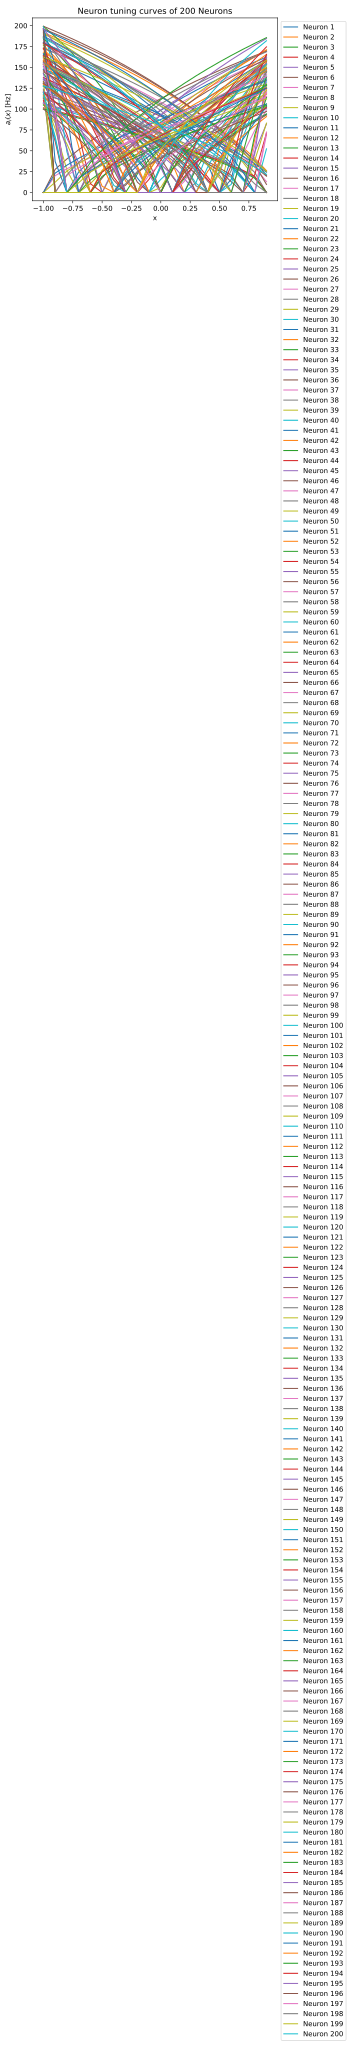

In [119]:
n = 200 # number of neurons
dx = 0.1  # Example step size
x = np.arange(-1, 1, dx)
tau_ref = 2.0e-3    
tau_RC = 20.0e-3

maximum_firing_rates = np.random.uniform(100, 200, size=(n, 1))
x_intercepts = np.random.uniform(-1, 1, size=(n, 1))
encoders = np.random.choice([1, -1], size=(n, 1))

def G(_J: np.ndarray):
    _J[_J > 1] = 1.0 / (tau_ref - tau_RC * np.log(1 - (1/_J[_J > 1])))
    _J[_J <= 1] = 0
    return _J

alphas = (- 1.0 + (1.0 / (1.0 - np.exp((1.0 / tau_RC) * (tau_ref - (1.0 / maximum_firing_rates)))))) / (1.0 - x_intercepts)
j_bias = (1.0 - (x_intercepts / (1.0 - np.exp((1.0 / tau_RC) * (tau_ref - (1.0 / maximum_firing_rates)))))) / (1.0 - x_intercepts)
A = G(alphas * encoders @ x.reshape(1, len(x)) + j_bias)

for i in range(n):
    plt.plot(x, A[i, :], label=f'Neuron {i+1}')

plt.title(f"Neuron tuning curves of {n} Neurons")
plt.xlabel('x')
plt.ylabel('$a_{i}(x)$ [Hz]')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

**b) Step input.** Repeat part (a) with an input that is ten randomly chosen values between -1 and 0, each one held for 0.1 seconds (a randomly varying step input)

In [120]:
# ✍ <YOUR SOLUTION HERE>

**c) Sinusoidal input.** Repeat part (a) with an input that is $x(t)=0.2\sin(6\pi t)$.

In [121]:
# ✍ <YOUR SOLUTION HERE>

**d) Discussion.** Briefly discuss the results for this question. Does the output match the ideal output? What kind of deviations do you see and why do those exist?

✍ \<YOUR SOLUTION HERE\>

# 5. Connecting three groups of neurons

**a) Sinusoidal input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for an input of $x(t)=\cos(3\pi t)$ and $y(t)=0.5 \sin (2 \pi t)$ (over $1\,\mathrm{s}$).

In [122]:
# ✍ <YOUR SOLUTION HERE>

**b) Random input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for a random input over $1\,\mathrm{s}$. For $x(t)$ use a random signal with a limit of $8\,\mathrm{Hz}$ and $\mathtt{rms}=1$. For $y(t)$ use a random signal with a limit of $5\,\mathrm{Hz}$ and $\mathtt{rms}=0.5$.

In [123]:
# ✍ <YOUR SOLUTION HERE>

# 6. Computing with vectors

**a) Constant inputs.** Plot the decoded output $\hat{w}(t)$ and the ideal $w$ for
		$$x =(0.5,1), \quad y = (0.1,0.3), \quad z =(0.2,0.1), \quad q = (0.4,-0.2) \,.$$

In [124]:
# ✍ <YOUR SOLUTION HERE>

**b) Sinusoidal input.** Produce the same plot for
$$x =(0.5,1), \quad y = (\sin(4\pi t),0.3), \quad z =(0.2,0.1), \quad q = (\sin(4\pi t),-0.2) \,.$$

In [125]:
# ✍ <YOUR SOLUTION HERE>

**c) Discussion.** Describe your results and discuss why and how they stray from the expected answer.

✍ \<YOUR SOLUTION HERE\>